<img src="../images/Boeing_full_logo.png" alt="Boeing" style="width: 400px;"/>

<br/>

<img src="../images/aeropython_logo.png" alt="AeroPython" style="width: 200px;"/>

# Cómo acelerar Python usando numba

_En ocasiones nos encontraremos con algoritmos que no serán fácilmente vectorizables o expresables en operaciones sobre arrays de NumPy, y sufriremos los problemas de rendimiento de Python. En este notebook vamos a hacer un repaso exhaustivo de **cómo acelerar sustancialmente nuestro código Python usando numba**. Esta clase está basada en el artículo http://pybonacci.org/2015/03/13/como-acelerar-tu-codigo-python-con-numba/ _

## ¿Qué es numba?

numba es un compilador JIT (_just-in-time_) de Python que genera código máquina para CPU o GPU utilizando la infraestructura LLVM especializado en aplicaciones numéricas. Vamos a ver un ejemplo muy básico de cómo funciona:

¿Impresionado? La primera vez que hemos llamado a la función, Python ha generado el código correspondiente al tipo de datos que le hemos pasado. Podemos verlo aquí:

E imprimir el código generado así:

## Entendiendo numba: el modo *nopython*

Como podemos leer en la documentación, [numba tiene dos modos de funcionamiento básicos](http://numba.pydata.org/numba-doc/0.17.0/user/jit.html#nopython): el modo *object* y el modo *nopython*.

* El modo *object* genera código que gestiona todas las variables como objetos de Python y utiliza la API C de Python para operar con ellas. En general en este modo **no habrá ganancias de rendimiento** (e incluso puede ir más lento), con lo cual mi recomendación personal es directamente no utilizarlo. Hay casos en los que numba puede detectar los bucles y optimizarlos individualmente (*loop-jitting*), pero no le voy a prestar mucha atención a esto.
* El modo *nopython* **genera código independiente de la API C de Python**. Esto tiene la desventaja de que no podemos usar todas las características del lenguaje, **pero tiene un efecto significativo en el rendimiento**. Otra de las restricciones es que **no se puede reservar memoria para objetos nuevos**.

Por defecto numba usa el modo *nopython* siempre que puede, y si no pasa a modo *object*. Nosotros vamos a **forzar el modo nopython** (o «modo estricto» como me gusta llamarlo) porque es la única forma de aprovechar el potencial de numba.

## Ámbito de aplicación

El problema del modo *nopython* es que los mensajes de error son totalmente inservibles en la mayoría de los casos, así que antes de lanzarnos a compilar funciones con numba conviene hacer un repaso de qué no podemos hacer para anticipar la mejor forma de programar nuestro código. Podéis consultar en la documentación [el subconjunto de Python soportado por numba](http://numba.pydata.org/numba-doc/0.17.0/reference/pysupported.html) en modo *nopython*, y ya os aviso que, al menos de momento, no tenemos [*list comprehensions*](https://github.com/numba/numba/issues/504), [delegación de generadores](https://github.com/numba/numba/issues/984) ni algunas cosas más. Permitidme que resalte una frase sacada de la página principal de numba:

> "*With a few annotations, **array-oriented and math-heavy Python code** can be just-in-time compiled to native machine instructions, similar in performance to C, C++ and Fortran*". [Énfasis mío]

Siento decepcionar a la audiencia pero *numba no acelerará todo el código Python* que le echemos: está enfocado a operaciones matemáticas con arrays. Aclarado este punto, vamos a ponernos manos a la obra con un ejemplo aplicado :)

## Acelerando una función con numba

Vamos a intentar acelerar la siguiente función, tomada del artículo http://pybonacci.org/2015/03/09/c-elemental-querido-cython/:

> "Por ejemplo, imaginemos que tenemos que detectar valores mínimos locales dentro de una malla. Los valores mínimos deberán ser simplemente valores más bajos que los que haya en los 8 nodos de su entorno inmediato. En el siguiente gráfico, el nodo en verde será un nodo con un mínimo y en su entorno son todo valores superiores:

<table>
 <tr>
  <td style="background:red">(2, 0)</td>
  <td style="background:red">(2, 1)</td>
  <td style="background:red">(2, 2)</td>
 </tr>
 <tr>
  <td style="background:red">(1, 0)</td>
  <td style="background:green">(1. 1)</td>
  <td style="background:red">(1, 2)</td>
 </tr>
 <tr>
  <td style="background:red">(0, 0)</td>
  <td style="background:red">(0, 1)</td>
  <td style="background:red">(0, 2)</td>
 </tr>
</table>

Creamos nuestro array de datos:

Y copiemos directamente la función original:

### Paso 0: Analizar el rendimiento

Guía sobre cómo analizar el rendimiento en Python: https://www.huyng.com/posts/python-performance-analysis

Parece que está habiendo demasiadas llamadas a `list.append`, aunque representan un porcentaje pequeño del tiempo de ejecución.

### Paso 1: Mejorar el algoritmo

Hacer `append` a esas dos listas tantas veces no parece una buena idea. De hecho, se puede comprobar que se hace para un porcentaje significativo de los elementos:

Tenemos que más de un 10 % de los elementos de la matriz cumplen la condición de ser «mínimos locales», así que no es nada despreciable. Esto en nuestro ejemplo hace *un total de más de 400 000 elementos*:

En lugar de esto, lo que vamos a hacer va a ser crear otro array, de la misma forma que nuestros datos, y almacenar un valor `True` en aquellos elementos que cumplan la condición de mínimo local. De esta forma cumplimos también una de las reglas de oro de Software Carpentry: "*Always initialize from data*".

Encima puedo aprovechar la estupenda función `nonzero` de NumPy. Compruebo que las salidas son iguales:

Y evalúo el rendimiento de la nueva función:

**Como era de esperar**, los tiempos son parecidos, porque no he optimizado el cuello de botella que son las comprobaciones de los arrays. Al menos, ya no tenemos dos objetos en memoria que van a crecer de manera aleatoria: ya podemos utilizar numba.

### Paso 2: Aplicar `numba.jit(nopython=True)`

Como hemos dicho antes, vamos a forzar que numba funcione en modo *nopython* para garantizar que obtenemos una mejora en el rendimiento. Si intentamos compilar la primera función, ya vamos a ver una ganancia de rendimiento sustancial:

¿Qué pasa si hacemos lo mismo con la versión que no utiliza listas?

Obtenemos un error porque numba no reconoce la función `np.zeros_like` con los argumentos que le hemos pasado. Si acudimos a la documentación http://numba.pydata.org/numba-doc/0.29.0/reference/numpysupported.html#other-functions, vemos que hay que utilizar tipos de NumPy, en este caso `np.bool_`.

Lo hemos conseguido: **70x más rápido** :)

## Ejercicios

### La atmósfera estándar

El **cálculo de propiedades termodinámicas de la atmósfera estándar** es un problema clásico que todo aeronáutico ha afrontado alguna vez muy al principio de su carrera formativa. La teoría es simple: imponemos una ley de variación de la temperatura con la altura $T = T(h)$, la presión se obtiene por consideraciones hidrostáticas $p = p(T)$ y la densidad por la ecuación de los gases ideales $\rho = \rho(p, T)$. La particularidad de la atmósfera estándar es que imponemos que la variación de la temperatura con la altura es una función simplificada *y definida a trozos*, así que calcular temperatura, presión y densidad dada una altura se parece mucho a hacer esto:

$$T(h) = \begin{cases} T_0 + \alpha h & 0 <= h <= 11000 \\ T(11000) & 11000 < h <= 20000 \end{cases}
\\ ~\\ T_0 = 288.16 K \\
\alpha = -6.5 \cdot 10^{-3}~\text{K/m}$$

$$ \rho(h) = \begin{cases} \rho_0 \left( \frac{T}{T_0} \right)^{-\frac{g}{\alpha R} - 1} & 0 <= h <= 11000 \\ \rho(11000)~e^{\frac{-g(z - 11000)}{R T}} & 11000 < h <= 20000 \end{cases} $$

$$\rho_0 = 1.225~\text{[SI]} \\
R = 287~\text{[SI]}$$

$$p = \rho R_a T$$

```python
if 0.0 <= h < 11000.0:
    T = T0 + alpha * h
    rho = ...  # Algo que depende de T
    p = rho * R_a * T
elif 11000.0 <= h < 20000.0:
    T = T1
    rho = ...
    p = rho * R_a * T
```

El problema viene cuando se quiere **vectorizar** esta función y permitir que `h` pueda ser un array de alturas. Esto es muy conveniente cuando queremos pintar alguna propiedad con matplotlib, por ejemplo.

Se intuye que hay dos formas de hacer esto: utilizando funciones de NumPy o iterando por cada elemento del array.

In [ ]:
# Constants
# Computed constants

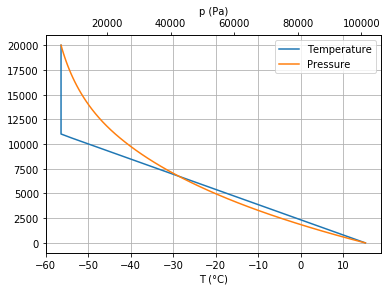

In [30]:
# aeropython: preserve
h = np.linspace(0, 20000)
T, p, _ = atm(h)

fig, ax1 = plt.subplots()

l1, = ax1.plot(T - 273, h, color="#1f77b4")
ax1.set_xlabel("T (°C)")

ax2 = ax1.twiny()
l2, = ax2.plot(p, h, color="#ff7f0e")
ax2.set_xlabel("p (Pa)")

ax1.legend((l1, l2), ["Temperature", "Pressure"], loc=0)
ax1.grid()

## Solución de Navier de una placa plana

Implementar y representar gráficamente la solución de Navier para calcular la deflexión de una placa rectangular, simplemente apoyada en sus cuatro bordes (es decir, los bordes pueden girar: no están empotrados) sometida a una carga transversal. La expresión matemática es:

$$w(x,y) = \sum_{m=1}^\infty \sum_{n=1}^\infty \frac{a_{mn}}{\pi^4 D}\,\left(\frac{m^2}{a^2}+\frac{n^2}{b^2}\right)^{-2}\,\sin\frac{m \pi x}{a}\sin\frac{n \pi y}{b}$$

siendo $a_{mn}$ los coeficientes de Fourier de la carga aplicada.

Para cada punto $(x, y)$ hay que hacer una doble suma en serie; si además queremos evaluar esto en un `meshgrid`, necesitamos **un cuádruple bucle**.

Maximum displacement = 0.101508051672 mm
alpha = 0.00831
alpha * P a^2 / D = 0.1416 mm


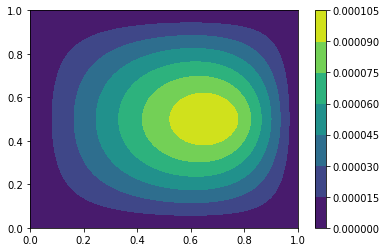

In [32]:
# aeropython: preserve
# Plate geometry
a = 1.0  # m
b = 1.0  # m
h = 50e-3  # m

# Material properties
E = 69e9  # Pa
nu = 0.35

# Series terms
max_m = 16
max_n = 16

# Computation points
# NOTE: With an odd number of points the center of the place is included in
# the grid
NUM_POINTS = 101

# Load
P = 10e3  # N
xi = 3 * a / 4
eta = a / 2

# Flexural rigidity
D = h**3 * E / (12 * (1 - nu**2))

# ---

# Set up domain
x = np.linspace(0, a, num=NUM_POINTS)
y = np.linspace(0, b, num=NUM_POINTS)
xx, yy = np.meshgrid(x, y)

# Compute displacement field
ww = np.zeros_like(xx)
plate_displacement(xx, yy, ww, a, b, P, xi, eta, D, max_m, max_n)

# Print maximum displacement
w_max = abs(ww).max()
print("Maximum displacement = %14.12f mm" % (w_max * 1e3))
print("alpha = %7.5f" % (w_max / (P * a**2 / D)))
print("alpha * P a^2 / D = %6.4f mm" % (0.01160 * P * a**2 / D * 1e3))

plt.contourf(xx, yy, ww)
plt.colorbar()

---
<br/>
#### <h4 align="right">¡Síguenos en Twitter!
<br/>
###### <a href="https://twitter.com/AeroPython" class="twitter-follow-button" data-show-count="false">Follow @AeroPython</a> <script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script> 
<br/>
###### Este notebook ha sido realizado por: Juan Luis Cano 
<br/>
##### <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es"><img alt="Licencia Creative Commons" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Curso AeroPython</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Juan Luis Cano Rodriguez y Alejandro Sáez Mollejo</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es">Licencia Creative Commons Atribución 4.0 Internacional</a>.

---
_Las siguientes celdas contienen configuración del Notebook_

_Para visualizar y utlizar los enlaces a Twitter el notebook debe ejecutarse como [seguro](http://ipython.org/ipython-doc/dev/notebook/security.html)_

    File > Trusted Notebook

In [ ]:
# Esta celda da el estilo al notebook